[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thrash-lab/sparse-growth-curve/blob/main/3_multiple_files_analysis.ipynb)

[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT) for the code.

[![License: CC BY-NC 4.0](https://img.shields.io/badge/License-CC%20BY--NC%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc/4.0/) for other contents.

#### **Authors**: Chuankai Cheng and J. Cameron Thrash(*)

Department of Biological Sciences, University of Southern California, Los Angeles, CA, USA




#### (*) Correspondence: J. Cameron Thrash
- University of Southern California
- 3616 Trousdale Pkwy, AHF 209
- Los Angeles, CA 90089, USA
- thrash@usc.edu

In [1]:
!wget https://raw.githubusercontent.com/thrash-lab/sparse-growth-curve/main/Growth_curve_data_example/LSUCC0096_all_salinity.xlsx \
!wget https://raw.githubusercontent.com/thrash-lab/sparse-growth-curve/main/Growth_curve_data_example/LSUCC0096_NaCl.xlsx \
!wget https://raw.githubusercontent.com/thrash-lab/sparse-growth-curve/main/Growth_curve_data_example/LSUCC0096_ionic_strength.xlsx \
!wget https://raw.githubusercontent.com/thrash-lab/sparse-growth-curve/main/Growth_curve_data_example/LSUCC0096_temperature.xlsx \
!wget https://raw.githubusercontent.com/thrash-lab/sparse-growth-curve/main/Growth_curve_data_example/LSUCC0096_thiosulfate_trns4.xlsx \

--2021-03-17 21:21:47--  https://raw.githubusercontent.com/thrash-lab/sparse-growth-curve/main/Growth_curve_data_example/LSUCC0096_all_salinity.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135034 (132K) [application/octet-stream]
Saving to: ‘LSUCC0096_all_salinity.xlsx’

LSUCC0096_all_salin 100%[===================>] 131.87K  --.-KB/s    in 0.02s   

2021-03-17 21:21:47 (5.89 MB/s) - ‘LSUCC0096_all_salinity.xlsx’ saved [135034/135034]

--2021-03-17 21:21:47--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2021-03-17 21:21:48--  https://raw.githubusercontent.com/thrash-lab/sparse-growth-curve/main/Growth_curve_data_example/LSUCC0096_NaCl.xlsx
Reusing existing connection to ra

## This example finds all the 'xlsx' files that have been uploaded and fits the growth curves in each file.

In [2]:
import pandas as pd #pandas for reading tables
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm
colormap=cm.tab10

import os
from os import listdir
from os.path import isfile, join

from datetime import datetime

from random import random

#statistical analysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,RANSACRegressor
from scipy import stats

from scipy.interpolate import interp1d

# datetime object containing current date and time
now = datetime.now()
 
#print("now =", now)

dt_string = now.strftime("%Y-%m-%d-%H_%M_%S")
print('Creating a time stamp:')
print("YYYY-MM-DD-hh_mm_ss =", dt_string)

print('Making output folder: output_'+dt_string)

output_folder='output_'+dt_string

if os.path.exists(output_folder)==False:
    os.mkdir(output_folder)

excel_files = np.array([f for f in listdir() if (isfile(f) & ('.xlsx' in f))])

file_names=[]
for s in excel_files:
  file_name=s.split('.xlsx')[0]
  print('Making folder:'+output_folder+'/'+file_name)
  os.mkdir(output_folder+'/'+file_name)
  file_names.append(file_name)
file_names=np.array(file_names)

Creating a time stamp:
YYYY-MM-DD-hh_mm_ss = 2021-03-17-21_21_49
Making output folder: output_2021-03-17-21_21_49
Making folder:output_2021-03-17-21_21_49/LSUCC0096_ionic_strength
Making folder:output_2021-03-17-21_21_49/LSUCC0096_all_salinity
Making folder:output_2021-03-17-21_21_49/LSUCC0096_thiosulfate_trns4
Making folder:output_2021-03-17-21_21_49/LSUCC0096_NaCl
Making folder:output_2021-03-17-21_21_49/LSUCC0096_temperature


# All the functions that are needed

In [3]:
def myLinearRegression_CB(x, y, x_fit, one_order=10):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  #print('\nFitting data:')
  #print('x = ', x)
  #print('y = ', y)

  corr=np.corrcoef(x,y)[0][1]
  #print('|corr|=', np.abs(corr))

  if (((np.abs(corr)<0.80) or (len(y)<4)) and 
      ((np.abs(corr)<0.90) or (len(y)<3)) and
      ((np.max(y)-np.min(y))<np.log2(one_order))):
    comp_y=np.median(y)*np.ones(len(y))
    pre_y=np.median(y)*np.ones(len(x_fit))
    doubling_rate=1e-6
  
  else:
    #Robust linear model estimation using RANSAC
    X=x.reshape(-1,1)
    if len(y)>4:
      try: 
        reg = RANSACRegressor()
        reg.fit(X, y)
        doubling_rate=reg.estimator_.coef_[0]
        inlier_mask = reg.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        
      except ValueError:
        #print('RANSAC could not find a valid consensus set.\n',
        #      'Running regular linear regression.')
        reg = LinearRegression()
        reg.fit(X,y)
        doubling_rate=reg.coef_[0]
    else:
        reg = LinearRegression()
        reg.fit(X,y)
        doubling_rate=reg.coef_[0]
    
    pre_y=reg.predict(x_fit.reshape(-1,1))
    comp_y=reg.predict(X)
  
  sigma=np.sqrt(
      np.sum(
          (comp_y-y)**2
          /
          (len(x)-1))
      )

  T_95 = stats.t.ppf(0.95, len(x)-1)

  G=np.sqrt(
      1/len(x)
      +
      (x_fit-np.mean(x))**2
      /
      sum((x-np.mean(x))**2)
      )

  ci=sigma*T_95*G
  
  #sigma**2/np.sum()

  return (doubling_rate, pre_y, ci)

In [4]:
def preprocessing_growth_curve(time, cell_density):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  t=np.array(time)
  X=np.array(cell_density)

  #for i in range(len(time)-3):
  #  t=np.r_[t,np.median(time[[i,i+1,i+2]])]
  #  X=np.r_[X, np.median(cell_density[[i,i+1, i+2]])]

  X=X[np.argsort(t)]
  t=t[np.argsort(t)]

  #You might get multiple cell counts for the same sample at one time.
  #Here, I merge the cell densities by their mean:
  #using the function "np.unique"
  #I get rid of the duplicated time points
  t1=np.unique(t) 
  X1=[]
  for tt in t1:
    temporary_cell_densities=X[t==tt]
    #Getting the mean cell density at a time point
    X1.append(np.median(temporary_cell_densities))
  X1=np.array(X1)

  return t1, X1

In [5]:
def phase_seperations(t, X, max_depth=1):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  gamma=np.diff(np.log2(X))/np.diff(t)
  gamma=np.r_[gamma, gamma, gamma]
  #gamma=np.r_[gamma[0], gamma]
  t_gamma=np.r_[t[0:-1],
                np.array([(t[i]+t[i+1])/2 for i in range(len(t)-1)]),
                t[1::]]

  gamma_2=np.diff(np.log2(X)[::2])/np.diff(t[::2])
  gamma_2=np.r_[gamma_2, gamma_2, gamma_2]
  t_gamma_2=np.r_[t[::2][0:-1],
                  [(t[::2][i]+t[::2][i+1])/2 for i in range(len(t[::2])-1)],
                  t[::2][1::]]


  gamma_3=np.diff(np.log2(X)[::3])/np.diff(t[::3])
  gamma_3=np.r_[gamma_3, gamma_3, gamma_3]
  t_gamma_3=np.r_[t[::3][0:-1],
                  [(t[::3][i]+t[::3][i+1])/2 for i in range(len(t[::3])-1)],
                  t[::3][1::]]

  all_t_gamma=np.r_[t_gamma,t_gamma_2, t_gamma_3]
  all_gamma=np.r_[gamma, gamma_2, gamma_3]

  all_gamma=all_gamma[np.argsort(all_t_gamma)]
  all_t_gamma=np.sort(all_t_gamma)

  all_gamma=np.array([np.median(all_gamma[[i,i+1,i+2,i+3,
                                          i+4,i+5,i+6,i+7,i+8]]) 
                      for i in range(len(all_t_gamma)-9)])
  all_t_gamma=np.array([np.median(all_t_gamma[[i,i+1,i+2,i+3,
                                              i+4,i+5,i+6,i+7,i+8]]) 
                      for i in range(len(all_t_gamma)-9)])

  sel_t_gamma=np.unique(all_t_gamma)
  sel_gamma=[]
  for stg in sel_t_gamma:
    sel_gamma.append(
        np.mean(all_gamma[all_t_gamma==stg]))
  sel_gamma=np.array(sel_gamma)

  # By default, max_depth = 1
  # Because for a standard growth curve (no diauxic shift) without death phase,
  # there would only be two states:
  # 1. Not growing (lag phase and stationary), growth rate is close to 0;
  # 2. Growing exponentially at an almost constant rate.

  regr_1 = DecisionTreeRegressor(max_depth=max_depth)
  regr_1.fit(all_t_gamma.reshape(-1, 1), all_gamma)

  t_fit = np.arange(0.0, t[-1], 0.01)[:, np.newaxis]
  gamma_fit = regr_1.predict(t_fit)

  #We find the state transition point
  gamma_fit_diff=np.diff(gamma_fit)
  inflection_points=t_fit[1::][gamma_fit_diff!=0]

  all_starting_time=np.r_[[0],inflection_points.reshape(1,-1)[0], t_fit[-1]]

  return all_starting_time

In [6]:
def phases_exponential_fit(phases_points, t, X, one_order):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  all_starting_time=phases_points

  all_doubling_rates=[]
  all_fit_time=[]
  all_fit_cell_density=[]
  all_fit_conf_band=[]

  #print('All phases points', all_starting_time)
  t_1 = np.arange(0.0, t[-1], 0.01)[:, np.newaxis]
  for i in range(len(all_starting_time)-1):
    start_t=all_starting_time[i]
    end_t=all_starting_time[i+1]

    #print('Time period: ', start_t, 'hours  ---', end_t, 'hours')
    # Chooseing the time period:
    sel_bool=(t>=start_t-1) & (t<=end_t+1)
    #if np.sum(sel_bool)<3:
    #  if np.where(sel_bool)[0][0]!=0 and np.where(sel_bool)[0][-1]!=len(sel_bool)-1:
    #    sel_bool[np.where(sel_bool)[0][0]-1]=True
    #    sel_bool[np.where(sel_bool)[0][-1]+1]=True
    #  elif np.where(sel_bool)[0][0]!=0:
    #    sel_bool[np.where(sel_bool)[0][0]-1]=True
    #  elif np.where(sel_bool)[0][-1]!=len(sel_bool)-1:
    #    sel_bool[np.where(sel_bool)[0][-1]+1]=True

    if np.sum(sel_bool)>=2:
      sel_t=t[sel_bool]
      sel_X=X[sel_bool]

      #print(sel_t, sel_X)

      fit_bool=(t_1>=start_t-1) & (t_1<=end_t+1)
      sel_t_1=t_1[fit_bool]

      (dr, pre_X_1, ci)=myLinearRegression_CB(
          sel_t, 
          np.log2(sel_X), 
          sel_t_1)
      
      all_doubling_rates.append(dr)
      all_fit_time.append(sel_t_1)
      all_fit_cell_density.append(2**pre_X_1)
      all_fit_conf_band.append(2**ci)

      #print('Doubling rate:', dr, 'doubling/hour')
      #print('\n')

    #else:
      #print('No data point in this time period, not fitting.')

  return (all_doubling_rates,
            all_fit_time,
            all_fit_cell_density,
            all_fit_conf_band)

In [7]:
def growth_death_rate_decision(all_fit_cell_density,
                               all_fit_time,
                               all_doubling_rates):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  #all_starting_time=phases_points
  all_acrossing_orders=[]
  for i in range(len(all_fit_cell_density)):
    start_t=all_fit_time[i][0]
    end_t=all_fit_time[i][-1]

    #print('\nTime period: ', start_t, 'hours  ---', end_t, 'hours')

    afc = all_fit_cell_density[i]
    acrossing_orders=np.log10(afc[-1])-np.log10(afc[0])
    all_acrossing_orders.append(acrossing_orders)
    
    #print('Doubling rate:', all_doubling_rates[i], 'doubling/hour')
    #print('Number of orders acrossing:', acrossing_orders)

  selected_doubling_rate=0
  selected_fit_time=0
  selected_fit_cell_density=all_fit_cell_density[0][0]

  selected_doubling_rate_d=0
  selected_fit_time_d=all_fit_time[-1][-1]
  selected_fit_cell_density_d=all_fit_cell_density[-1][-1]

  #Growth phase:
  if max(all_acrossing_orders)>0:
    selected_i=np.argmax(all_acrossing_orders)
    selected_doubling_rate=all_doubling_rates[selected_i]
    selected_fit_time=all_fit_time[selected_i]
    selected_fit_cell_density=all_fit_cell_density[selected_i]

  #Death phase:
  if min(all_acrossing_orders)<0:
    selected_i_d=np.argmin(all_acrossing_orders)
    selected_doubling_rate_d=all_doubling_rates[selected_i_d]
    selected_fit_time_d=all_fit_time[selected_i_d]
    selected_fit_cell_density_d=all_fit_cell_density[selected_i_d]

  return (selected_doubling_rate,
          selected_fit_time,
          selected_fit_cell_density,
          selected_doubling_rate_d,
          selected_fit_time_d,
          selected_fit_cell_density_d)

In [8]:
def fit_growth_curve(time, cell_density, one_order=10, decision_tree_depth=1):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  t1,X1=preprocessing_growth_curve(time, cell_density)
  phases_points=phase_seperations(t1, X1, max_depth=decision_tree_depth)

  #print(phases_points)
  
  (all_doubling_rates,
            all_fit_time,
            all_fit_cell_density,
            all_fit_conf_band)=phases_exponential_fit(phases_points, t1, X1, 
                                                 one_order)

  (selected_doubling_rate,
          selected_fit_time,
          selected_fit_cell_density,
          selected_doubling_rate_d,
          selected_fit_time_d,
          selected_fit_cell_density_d)=growth_death_rate_decision(
                               all_fit_cell_density,
                               all_fit_time,
                               all_doubling_rates)
          
  return (all_fit_time,
          all_fit_cell_density,
          all_fit_conf_band,
          selected_doubling_rate,
          selected_fit_time,
          selected_fit_cell_density,
          selected_doubling_rate_d,
          selected_fit_time_d,
          selected_fit_cell_density_d)

In [9]:
def read_file_2_df(input_file):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  #Read the data
  df=pd.read_excel(
      input_file+'.xlsx', sheet_name='Data').fillna(method='ffill')

  df.columns=df.columns.str.strip()
  file_data_frame=df[['Strain', 'Replicate', 
                      'Cell density', 'Time', 'Condition']]

  file_data_units=pd.read_excel(input_file+'.xlsx', 
                                sheet_name='Units', index_col=0).fillna(' ')

  condition_unit=file_data_units.loc['Condition'].values[0]
  time_unit=str(file_data_units.loc['Time'].values[0])
  cell_density_unit=str(file_data_units.loc['Cell density'].values[0])

  return (file_data_frame, file_data_units, 
          condition_unit, time_unit, cell_density_unit)

In [10]:
def fit_growth_curves(input_file, file_data_frame, file_data_units, 
          condition_unit, time_unit, cell_density_unit):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  output_data_indices=file_data_frame.groupby(
      ['Strain','Replicate','Condition']
      ).size().reset_index().rename(columns={0:'count'}
                                    )[['Strain','Replicate','Condition']]

  strains_conditions=output_data_indices.groupby(['Strain','Condition']
                              ).size().reset_index()[['Strain','Condition']]

  output_data_indices['Growth: Doubling rate']=0
  output_data_indices['Death: Doubling rate']=0

  output_data_indices=output_data_indices.astype(object)
  output_data_indices=output_data_indices.sort_values(by=['Strain','Condition'])

  strains=np.unique(strains_conditions['Strain'])
  row_num=len(strains)
  col_num=np.int(np.ceil(len(strains_conditions)/len(strains)))

  plt.figure(figsize=(col_num*2+1,
                      row_num*2+1))

  plot_j=1
  previous_condition=output_data_indices['Condition'].values[0]
  plt.subplot(row_num, col_num, plot_j)
  color_i=0
  plt.title(str(output_data_indices['Strain'].values[0])+'\n'
            +str(output_data_indices['Condition'].values[0])+' '
            +condition_unit)
  plt.ylabel(cell_density_unit)
  plt.xlabel(time_unit)

  for i in output_data_indices.index:
    target_gr_index=output_data_indices.loc[i]

    target_growth_curve_df = file_data_frame[
    (file_data_frame['Strain']==target_gr_index['Strain'])&
    (file_data_frame['Condition']==target_gr_index['Condition']) &
    (file_data_frame['Replicate']==target_gr_index['Replicate'])]

    #print('\n\nStrain:', target_gr_index['Strain'], 
    #      '\t Condition:',str(target_gr_index['Condition'])+' '+condition_unit,
    #      '\t Replicate:',str(target_gr_index['Replicate']))

    time=target_growth_curve_df.loc[:,'Time'].values
    cell_density=target_growth_curve_df.loc[:,'Cell density'].values

    #print('time=', time)
    #print('cell density=', 'cell_density')

    if target_gr_index['Condition']!=previous_condition:
      plt.yscale('log')
      plt.ylim(10**np.floor(np.log10(np.min(file_data_frame['Cell density']))-1),
              10**np.ceil(np.log10(np.max(file_data_frame['Cell density']))+1))
      
      plt.legend()
      #plt.xlim(np.floor(np.min(file_data_frame['Time'])),
      #         np.ceil(np.max(file_data_frame['Time'])))
      color_i=0
      plot_j+=1
      plt.subplot(row_num, col_num, plot_j)
      plt.title(str(target_gr_index['Strain'])+'\n'
                +str(target_gr_index['Condition'])+' '
                +condition_unit)
      
      plt.ylabel(cell_density_unit)
      plt.xlabel(time_unit)

    if len(cell_density)>4:
      (all_fit_time,
              all_fit_cell_density,
              all_fit_conf_band,
              selected_doubling_rate,
              selected_fit_time,
              selected_fit_cell_density,
              selected_doubling_rate_d,
              selected_fit_time_d,
              selected_fit_cell_density_d)=fit_growth_curve(
                  time, cell_density, one_order=10, decision_tree_depth=1)
      output_data_indices.loc[i,'Growth: Doubling rate']=selected_doubling_rate
      output_data_indices.loc[i,'Death: Doubling rate']=selected_doubling_rate_d

      for k in range(len(all_fit_time)):
          #plt.plot(all_fit_time[i], all_fit_cell_density[i], 'k--')
          #plt.fill_between(all_fit_time[k], 
          #                all_fit_cell_density[k]*(all_fit_conf_band[k]),
          #                all_fit_cell_density[k]/(all_fit_conf_band[k]),
          #                color=colormap(color_i), alpha=0.1)
          plt.plot(selected_fit_time, selected_fit_cell_density, '-', 
                  color=colormap(color_i), linewidth=2)
          
          plt.plot(selected_fit_time_d, selected_fit_cell_density_d, '--', 
                  color=colormap(color_i), linewidth=1)  

    elif len(cell_density)>2:
      x=time
      y=np.log2(cell_density)
      x_fit = np.arange(0.0, x[-1], 0.01)[:, np.newaxis]
      (doubling_rate, pre_y, ci) = myLinearRegression_CB(x, y, x_fit, one_order=10)

      #plt.fill_between(x_fit, 
      #                pre_y*ci,
      #                pre_y/ci,
      #                color=colormap(color_i), alpha=0.1)
          
      if doubling_rate>0:
        output_data_indices.loc[i,'Growth: Doubling rate']=doubling_rate
        plt.plot(x_fit, pre_y, '-', color=colormap(color_i), linewidth=2)
      else:
        output_data_indices.loc[i,'Death: Doubling rate']=doubling_rate
        plt.plot(x_fit, pre_y, '--', color=colormap(color_i), linewidth=1)

    elif len(cell_density)==2:
      x=time
      y=np.log2(cell_density)
      doubling_rate=(y[1]-y[0])/(x[1]-x[0])
      output_data_indices.loc[i,'Growth: Doubling rate']=doubling_rate
      if doubling_rate>0:
        output_data_indices.loc[i,'Growth: Doubling rate']=doubling_rate
        plt.plot(x, y, '-', color=colormap(color_i), linewidth=2)
      else:
        output_data_indices.loc[i,'Death: Doubling rate']=doubling_rate
        plt.plot(x, y, '--', color=colormap(color_i), linewidth=1)     

    plt.plot(time, cell_density,'o',alpha=0.3, color=colormap(color_i),
            label=output_data_indices.loc[i]['Replicate'])
    color_i+=1
    previous_condition=output_data_indices.loc[i]['Condition']

  plt.yscale('log')
  plt.ylim(10**np.floor(np.log10(np.min(file_data_frame['Cell density']))-1),
          10**np.ceil(np.log10(np.max(file_data_frame['Cell density']))+1))

  #plt.xlim(np.floor(np.min(file_data_frame['Time'])),
  #         np.ceil(np.max(file_data_frame['Time'])))
  plt.legend()
  plt.tight_layout()

  output_file_string=(output_folder+
                      '/'+input_file+
                      '/1_Data_fit_visualization_'+
                      dt_string+'.pdf')
  plt.savefig(output_file_string)

  print('output file saved:'+output_file_string)

  return output_data_indices

In [11]:
pip install XlsxWriter

     |████████████████████████████████| 153kB 7.0MB/s 


In [12]:
import xlsxwriter

def save_output_file(input_file, output_data_indices, file_data_units,
                     file_data_frame):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  growth_rates_output_df=output_data_indices
  growth_rates_output_df[
                        'Growth: Specific rate'
                        ]=growth_rates_output_df[
                                                  'Growth: Doubling rate'
                                                  ]*np.log(2)

  growth_rates_output_df[
                        'Death: Specific rate'
                        ]=growth_rates_output_df[
                                                  'Death: Doubling rate'
                                                  ]*np.log(2)

  growth_rates_output_units=file_data_units

  for c in growth_rates_output_df.columns:
    if 'Specific' in c:
      growth_rates_output_units.loc[c, 'Unit']='1/'+time_unit
    elif 'Doubling' in c:
      growth_rates_output_units.loc[c, 'Unit']='doubling/'+time_unit
    else:
      growth_rates_output_units.loc[c, 'Unit']=' '

  #growth_rates_output_df['Condition']=growth_rates_output_df['Condition'].astype(str)+' degree C'
  #conditions_unique=np.sort(np.unique(growth_rates_output_df['Condition']))
  #condition_dict=dict(zip(conditions_unique, range(len(conditions_unique))))

  # Create a Pandas Excel writer using XlsxWriter as the engine.
  writer = pd.ExcelWriter(output_folder+'/'+input_file+
                          '/Growth_rates_table_'+dt_string+'.xlsx', 
                          engine='xlsxwriter')

  # Write each dataframe to a different worksheet.
  growth_rates_output_df.to_excel(writer, sheet_name='Growth rates')
  growth_rates_output_units.to_excel(writer, sheet_name='Unit')
  file_data_frame.to_excel(writer, sheet_name='Data')

  # Close the Pandas Excel writer and output the Excel file.
  writer.save()

  return growth_rates_output_df

In [13]:
def strain_growth_rates(input_file, output_data_indices, file_data_units,
                     file_data_frame):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  fig, ax = plt.subplots(constrained_layout=True,
                        figsize=(8,4))
  ri=0
  all_targets=np.unique(growth_rates_output_df['Strain'].values)

  all_scatter_x=[]
  all_scatter_y=[]
  all_scatter_c=[]

  for ri in range(len(all_targets)):
    target=all_targets[ri]
    plot_box_df=growth_rates_output_df[growth_rates_output_df['Strain']==target]

    jittering_array=[]
    for k in range(len(plot_box_df)):
      jittering_array.append(ri+0.2*(random()-0.5))

    all_scatter_x=np.r_[all_scatter_x, jittering_array]
    all_scatter_y=np.r_[all_scatter_y, plot_box_df['Growth: Specific rate'].values]
    all_scatter_c=np.r_[all_scatter_c, plot_box_df['Condition'].values]

    bp = ax.boxplot(plot_box_df['Growth: Specific rate'], 
              positions=[ri])
    
    #ax.set_xticklabels(all_targets)

    #for element in ['boxes', 'whiskers', 'means', 'medians', 'caps']:
    #            plt.setp(bp[element], color=colormap(ri))

  ax.plot(range(len(all_targets)), 
          np.zeros(len(all_targets)), 'k--', alpha=0.5)

  ax.set_xticklabels(all_targets)

  #xticks=np.array(ax.get_xticklabels(), dtype=object)
  #for ri in range(len(xticks)):
  #  xticks[ri].set_color(colormap(ri))

  try:
    all_scatter_c=all_scatter_c.astype(float)
    sc = ax.scatter(all_scatter_x, all_scatter_y,
                    c=all_scatter_c, alpha=0.8, cmap='coolwarm')
    cbar=fig.colorbar(sc)
  except:
    print('Conditions are not numerical values.')
    conditions_unique=np.sort(np.unique(growth_rates_output_df['Condition']))
    condition_dict=dict(zip(conditions_unique, range(len(conditions_unique))))
    c_index=np.array([condition_dict[all_scatter_c[i]] 
              for i in range(len(all_scatter_c))])
    sc = ax.scatter(all_scatter_x, all_scatter_y,
                    c=c_index, alpha=0.8, cmap='jet')
    
    cbar=fig.colorbar(sc)
    cbar.ax.set_yticklabels(conditions_unique)

  cbar.ax.set_ylabel(condition_unit)

  secax = ax.secondary_yaxis('right', functions=(lambda x: x / np.log(2),
                                                lambda x: x * np.log(2)))

  ax.set_ylabel('Specific growth rate (1/'+time_unit+')')
  secax.set_ylabel('Doubling rate (doubling/'+time_unit+')')

  output_file_string=(output_folder+'/'+
                      input_file+'/2_Strain_growth_boxplot_'+
                      dt_string+'.pdf')
  
  plt.savefig(output_file_string)
  print('output file saved:'+output_file_string)

In [14]:
def growth_condition_dependence(input_file, growth_rates_output_df):
  """
  :Authors:
    Chuankai Cheng <chuankai@usc.edu> and J. Cameron Thrash <thrash@usc.edu>
  :License:
    MIT
  :Version:
    1.0
  :Date:
    2021-03-17
  :Repository: https://github.com/thrash-lab/sparse-growth-curve
  """
  # For testing use
  #growth_rates_output_df[
  #        'Condition str']=growth_rates_output_df[
  #                                    'Condition'].astype(str)+' degree C'

  layer_1='Strain'
  #layer_2='Condition str'
  layer_2='Condition'

  all_targets=np.unique(growth_rates_output_df[layer_1].values)
  numerical_flag=True

  %matplotlib inline
  fig, ax = plt.subplots(constrained_layout=True,
                        figsize=(8,4))

  shapes=['o', '^', 's', '>', 'D', 'd', '<']


  try: 
    growth_rates_output_df[
        layer_2]=growth_rates_output_df[
                                    layer_2].astype(float)

    for ri in range(len(all_targets)):
      target=all_targets[ri]
      plot_df=growth_rates_output_df[growth_rates_output_df[layer_1]==target]

      strain_df=plot_df[[layer_2, 'Growth: Specific rate']].astype(float)
      mean_GR_df=strain_df.groupby(layer_2).mean()
      min_GR_df=strain_df.groupby(layer_2).min()
      max_GR_df=strain_df.groupby(layer_2).max()

      layer_2_values=strain_df[layer_2].values
      fit_layer_2=np.arange(np.min(layer_2_values), 
                              np.max(layer_2_values), 0.01)
        
      f = interp1d(mean_GR_df.index, mean_GR_df['Growth: Specific rate'],
                    kind='quadratic')
        
      f_min = interp1d(mean_GR_df.index, min_GR_df['Growth: Specific rate'],
                    kind='quadratic')
        
      f_max = interp1d(mean_GR_df.index, max_GR_df['Growth: Specific rate'],
                    kind='quadratic')

      ax.fill_between(fit_layer_2, f_min(fit_layer_2),f_max(fit_layer_2),
              color=colormap(ri), alpha=0.1)
        
      ax.plot(fit_layer_2, f(fit_layer_2), '-',linewidth=2,
              color=colormap(ri))
        
      ax.plot(strain_df[layer_2], strain_df['Growth: Specific rate'], 
                shapes[ri], alpha=0.5, label=target)                                 
  except:
    print(layer_2+' is not numerical')
    growth_rates_output_df[
          layer_2]=growth_rates_output_df[
                                      layer_2].astype(str)

    numerical_flag=False

    layer_1_array=np.unique(growth_rates_output_df[layer_1].values)
    layer_1_dict=dict(zip(layer_1_array, range(len(layer_1_array))))

    layer_2_array=np.unique(growth_rates_output_df[layer_2].values)
    layer_2_dict=dict(zip(layer_2_array, range(len(layer_2_array))))

    growth_rates_output_df[layer_1+' index']=[layer_1_dict[s] 
                                              for s in growth_rates_output_df[layer_1]]
    growth_rates_output_df[layer_2+' index']=[layer_2_dict[s] 
                                              for s in growth_rates_output_df[layer_2]]

    growth_rates_output_df['Visualization X'
    ]=growth_rates_output_df[layer_2+' index'
    ]*10+5/len(layer_1_array)*growth_rates_output_df[layer_1+' index']

    growth_rates_output_df['Visualization X jittering'
    ]=[random()-0.5 for i in range(len(growth_rates_output_df.index))]

    for j in range(len(layer_1_array)):
      s=layer_1_array[j]
      plot_df=growth_rates_output_df[growth_rates_output_df[layer_1]==s]

      for c in layer_2_array:
        plot_box_df=plot_df[plot_df[layer_2]==c]
        bp = ax.boxplot(plot_box_df['Growth: Specific rate'], 
                positions=[plot_box_df['Visualization X'].values[0]],
                widths=10/len(layer_1_array))
        for element in ['boxes', 'whiskers', 'means', 'medians', 'caps']:
          plt.setp(bp[element], color=colormap(j))

      ax.scatter(plot_df['Visualization X']+
                  2/len(layer_1_array)*plot_df['Visualization X jittering'],
                  plot_df['Growth: Specific rate'],s=50,
                  label=s, alpha=0.5, marker=shapes[j%len(shapes)])
      
    ax.set_xticks(np.unique(plot_df['Visualization X'].values))
    ax.set_xticklabels(layer_2_array, rotation=90)                                

  secax = ax.secondary_yaxis('right', functions=(lambda x: x / np.log(2),
                                                lambda x: x * np.log(2)))

  secax.set_ylabel('Doubling rate (doubling/'+time_unit+')')

  ax.set_ylabel('Specific growth rate (1/'+time_unit+')')
  ax.set_xlabel(condition_unit)

  #if numerical_flag==True:
  plt.legend()

  output_file_string=(output_folder+'/'+
                      input_file+'/3_Condition_growth_plot_'+
                      dt_string+'.pdf')
  plt.savefig(output_file_string)

# Run the script in batch

Processing:LSUCC0096_ionic_strength.xlsx
output file saved:output_2021-03-17-21_21_49/LSUCC0096_ionic_strength/1_Data_fit_visualization_2021-03-17-21_21_49.pdf
output file saved:output_2021-03-17-21_21_49/LSUCC0096_ionic_strength/2_Strain_growth_boxplot_2021-03-17-21_21_49.pdf
Processing:LSUCC0096_all_salinity.xlsx
output file saved:output_2021-03-17-21_21_49/LSUCC0096_all_salinity/1_Data_fit_visualization_2021-03-17-21_21_49.pdf
output file saved:output_2021-03-17-21_21_49/LSUCC0096_all_salinity/2_Strain_growth_boxplot_2021-03-17-21_21_49.pdf
Processing:LSUCC0096_thiosulfate_trns4.xlsx
output file saved:output_2021-03-17-21_21_49/LSUCC0096_thiosulfate_trns4/1_Data_fit_visualization_2021-03-17-21_21_49.pdf
Conditions are not numerical values.
output file saved:output_2021-03-17-21_21_49/LSUCC0096_thiosulfate_trns4/2_Strain_growth_boxplot_2021-03-17-21_21_49.pdf
Condition is not numerical
Processing:LSUCC0096_NaCl.xlsx
output file saved:output_2021-03-17-21_21_49/LSUCC0096_NaCl/1_Data_f

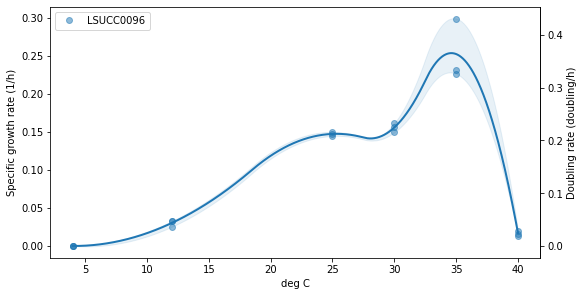

In [15]:
for fn in file_names:
  input_file=fn
  print('Processing:'+input_file+'.xlsx')
  (file_data_frame, file_data_units, 
   condition_unit, time_unit, cell_density_unit)=read_file_2_df(input_file)
  output_data_indices=fit_growth_curves(input_file, file_data_frame, file_data_units, 
          condition_unit, time_unit, cell_density_unit)
  growth_rates_output_df=save_output_file(input_file, output_data_indices, file_data_units,
                     file_data_frame)
  strain_growth_rates(input_file, output_data_indices, file_data_units,
                     file_data_frame)
  growth_condition_dependence(input_file, growth_rates_output_df)

# Zip the output folder

In [16]:
!zip -r $output_folder'.zip' $output_folder

  adding: output_2021-03-17-21_21_49/ (stored 0%)
  adding: output_2021-03-17-21_21_49/LSUCC0096_all_salinity/ (stored 0%)
  adding: output_2021-03-17-21_21_49/LSUCC0096_all_salinity/2_Strain_growth_boxplot_2021-03-17-21_21_49.pdf (deflated 30%)
  adding: output_2021-03-17-21_21_49/LSUCC0096_all_salinity/1_Data_fit_visualization_2021-03-17-21_21_49.pdf (deflated 39%)
  adding: output_2021-03-17-21_21_49/LSUCC0096_all_salinity/Growth_rates_table_2021-03-17-21_21_49.xlsx (deflated 6%)
  adding: output_2021-03-17-21_21_49/LSUCC0096_all_salinity/3_Condition_growth_plot_2021-03-17-21_21_49.pdf (deflated 3%)
  adding: output_2021-03-17-21_21_49/LSUCC0096_ionic_strength/ (stored 0%)
  adding: output_2021-03-17-21_21_49/LSUCC0096_ionic_strength/2_Strain_growth_boxplot_2021-03-17-21_21_49.pdf (deflated 31%)
  adding: output_2021-03-17-21_21_49/LSUCC0096_ionic_strength/1_Data_fit_visualization_2021-03-17-21_21_49.pdf (deflated 37%)
  adding: output_2021-03-17-21_21_49/LSUCC0096_ionic_strength/Gr